In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Inspect database for info
inspector = inspect(engine)

columns = inspector.get_columns('measurement')
measureCols = []
for c in columns:
    measureCols.append(c['name'])
    
columns = inspector.get_columns('station')
stationCols = []
for c in columns:
    stationCols.append(c['name'])

# Exploratory Climate Analysis

In [11]:
# Calculate the date 1 year ago from today
qryLD = session.query(func.max(Measurement.date).label("lastDay")).one()
maxDate = qryLD.lastDay
lastDay = dt.strptime(maxDate, '%Y-%m-%d')
print(lastDay)
pastYear = lastDay - relativedelta(years=1)
print(pastYear)

2017-08-23 00:00:00
2016-08-23 00:00:00


In [12]:
# Perform a query to retrieve the date and precipitation scores
prcpData = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= pastYear)

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcpDF = pd.DataFrame(prcpData[:-1], columns=["Date", "precipitation"])
prcpDateDF = prcpDF.set_index("Date")

In [14]:
# Clean dataframe
prcpDFclean = prcpDateDF.dropna()
print(len(prcpDFclean))
prcpDFclean.head()

2014


,precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [15]:
# Sort the dataframe by date
prcpDFclean = prcpDFclean.sort_index(ascending=True)
prcpDFclean.head()

,precipitation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


<IPython.core.display.Javascript object>


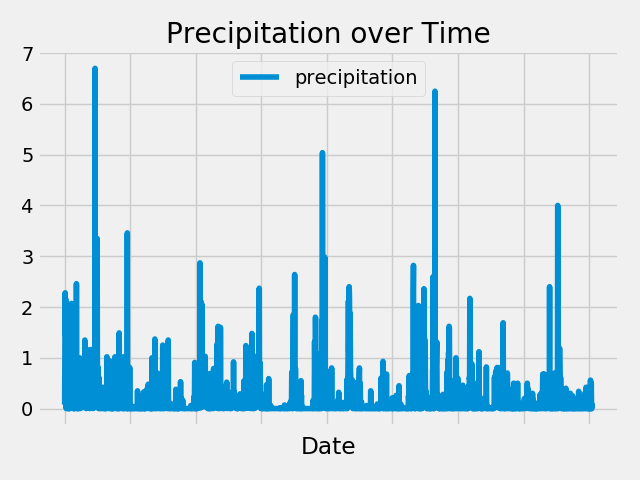

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
prcpDFclean.plot()

# Set a Title and labels
plt.title("Precipitation over Time")
plt.legend(loc="best")
plt.tight_layout()

![precipitation](Images/precipitation.png)

In [17]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcpDFclean.describe()

,precipitation
count,2014.000000
mean,0.176326
std,0.460362
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Station Analysis

In [18]:
# How many stations are available in this dataset?
session.query(Measurement.station).group_by(Measurement.station).count()

9

In [19]:
# What are the most active stations?
# List the stations and the counts in descending order.
stationCount = func.count(Measurement.station)
session.query(Measurement.station, stationCount).group_by(Measurement.station).order_by(stationCount.desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
minTemp = func.min(Measurement.tobs).label("Lowest Temperature")
maxTemp = func.max(Measurement.tobs).label("Highest Temperature")
avgTemp = func.avg(Measurement.tobs).label("Average Temperature")

session.query(minTemp, maxTemp, avgTemp).filter_by(station="USC00519281").all()

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
popStationData = session.query(Measurement.date, Measurement.tobs).filter_by(station="USC00519281").filter(Measurement.date >= pastYear).all()

In [22]:
# Save the query results as a Pandas DataFrame and set the index to the date column
tobsDF = pd.DataFrame(popStationData[:-1], columns=["date", "Temperature"])
tobsDateDF = tobsDF.set_index("date")

# Sort the dataframe by date
tobsDateDF = tobsDateDF.sort_values(by=["date"], ascending=False)

# Clean dataframe
tobsDateDFclean = tobsDateDF.dropna(axis=0, how="any")
tobsDateDFclean.head()

,Temperature
date,
2017-08-17,76.0
2017-08-16,76.0
2017-08-15,77.0
2017-08-14,77.0
2017-08-13,77.0


<IPython.core.display.Javascript object>


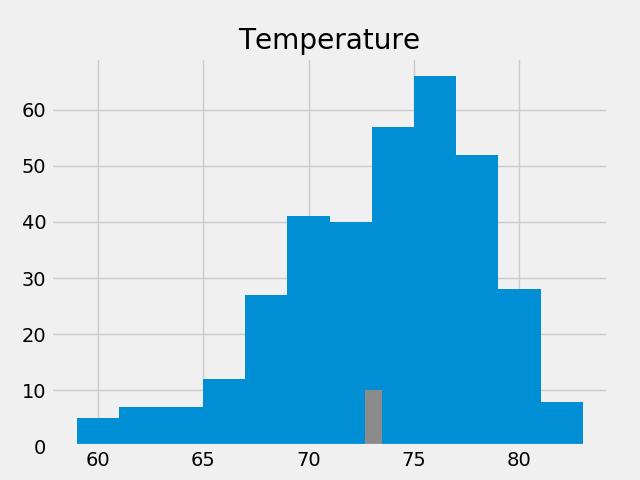

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000213EF50E7B8>]],
      dtype=object)

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
tobsDateDFclean.hist(bins=12)

## Temperature Analysis (optional)

In [24]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    startDate = dt.strptime(start_date, '%Y-%m-%d')
    endDate = dt.strptime(end_date, '%Y-%m-%d')
    minTemp = func.min(Measurement.tobs).label("minTemp")
    maxTemp = func.max(Measurement.tobs).label("maxTemp")
    avgTemp = func.avg(Measurement.tobs).label("avgTemp")
    result = session.query(minTemp, maxTemp, avgTemp).filter(endDate >= startDate).one()
    TMIN = result.minTemp
    TMAX = result.maxTemp
    TAVG = result.avgTemp
    return {"Lowest Temperature": TMIN, "Highest Temperature": TMAX, "Average Temperature": TAVG}
   
print(calc_temps('2014-02-28', '2015-03-05'))

{'Lowest Temperature': 53.0, 'Highest Temperature': 87.0, 'Average Temperature': 73.09795396419437}


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
hawaiiTrip = calc_temps("2015-12-26", "2016-01-02")
print(hawaiiTrip)

{'Lowest Temperature': 53.0, 'Highest Temperature': 87.0, 'Average Temperature': 73.09795396419437}


In [26]:
hawaiiTrip["Average Temperature"]

73.09795396419437